In [3]:
import os
print(f'Current working directory: {os.getcwd()}')
os.chdir(os.path.dirname(os.getcwd()))
print(f'Current working directory: {os.getcwd()}')

Current working directory: /home/exotic_ninja/Projects/ner_seq2seq_project/notebooks
Current working directory: /home/exotic_ninja/Projects/ner_seq2seq_project


In [4]:
from src.neural_baseline import *
from src.utils.conlleval import *

print(f'Current working directory: {os.getcwd()}')
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload

# notebook will reload external python modules;
%autoreload 2 

2023-06-15 15:00:41.946446: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 15:00:42.288486: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 15:00:42.291397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 15:00:43.748007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/exotic_ninja/Projects/ner_seq2seq_project/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current working directory: /home/exotic_ninja/Projects/ner_seq2seq_project


#### util functions

In [39]:
def calculate_metrics(dataset, ner_model, mapping):
    all_true_tag_ids, all_predicted_tag_ids = [], []
    
    for x, y in dataset:
        output = ner_model.predict(x, verbose=0)  # set verbose to 0
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]
    real_tags = [mapping[tag] for tag in all_true_tag_ids]
    
    res = evaluate(real_tags, predicted_tags, verbose = True)

    return res

## Baseline n°1: Neural Network Implementation with Keras

In [38]:
conll_data = load_and_prepare_data()

Found cached dataset conll2003 (/home/exotic_ninja/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 562.84it/s]


In [37]:
conll_data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [62]:
vocab_size = 20000
batch_size = 32
epochs = 10
sample_text = "eu rejects german call to boycott british lamb"


print(f"processing data and preparing vocabulary of size {vocab_size}...")    
conll_data = load_and_prepare_data()

mapping = make_tag_lookup_table()

# vocab_size = 20000
vocabulary = get_vocabulary(conll_data, vocab_size)

print(f"preparing datasets...")
lookup_layer = keras.layers.StringLookup(vocabulary=vocabulary)

# batch_size = 32
train_dataset, val_dataset, test_dataset = prepare_datasets(vocabulary, batch_size)

num_tags = len(mapping)

print(f"creating model...\n")
ner_model = create_model(num_tags, vocab_size)

print(f"training model...\n")
history = compile_and_fit(ner_model, train_dataset, epochs=epochs, val_dataset=val_dataset)

439/439 [==============================] - 14s 33ms/step - loss: 0.2539 - val_loss: 0.2787
Epoch 3/10
439/439 [==============================] - 13s 29ms/step - loss: 0.1561 - val_loss: 0.2541
Epoch 4/10
439/439 [==============================] - 13s 30ms/step - loss: 0.1215 - val_loss: 0.2401
Epoch 5/10
439/439 [==============================] - 14s 32ms/step - loss: 0.0999 - val_loss: 0.2434
Epoch 6/10
439/439 [==============================] - 15s 34ms/step - loss: 0.0837 - val_loss: 0.2419
Epoch 7/10
439/439 [==============================] - 13s 29ms/step - loss: 0.0690 - val_loss: 0.2514
Epoch 8/10
439/439 [==============================] - 11s 24ms/step - loss: 0.0578 - val_loss: 0.2673
Epoch 9/10
439/439 [==============================] - 12s 26ms/step - loss: 0.0497 - val_loss: 0.2977
Epoch 10/10
439/439 [==============================] - 11s 25ms/step - loss: 0.0449 - val_loss: 0.2870


In [25]:
for x, y in val_dataset:
    print(x.shape,y.shape)
    break

(32, 41) (32, 41)


### Metrics on validation set

In [41]:
print('Sample text:', sample_text)
print('Predicted tags:')
print(predict_sample(ner_model, sample_text, mapping, lookup_layer))

print(f"\ncalculating metrics...\n")
res = calculate_metrics(val_dataset, ner_model, mapping)

# res is a tuple of (precision, recall, f1), print it out beautifully
print("\n")
print(f"precision: \t{res[0]:.2f}")
print(f"   recall: \t{res[1]:.2f}")
print(f"       f1: \t{res[2]:.2f}")

Sample text: eu rejects german call to boycott british lamb
Predicted tags:
1/1 [==============================] - 0s 398ms/step
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O']

calculating metrics...

processed 51362 tokens with 5942 phrases; found: 5439 phrases; correct: 3933.
accuracy:  64.18%; (non-O)
accuracy:  93.55%; precision:  72.31%; recall:  66.19%; FB1:  69.12
              LOC: precision:  82.43%; recall:  80.73%; FB1:  81.57  1799
             MISC: precision:  75.69%; recall:  65.84%; FB1:  70.42  802
              ORG: precision:  66.56%; recall:  63.53%; FB1:  65.01  1280
              PER: precision:  63.61%; recall:  53.80%; FB1:  58.29  1558


precision: 	72.31
   recall: 	66.19
       f1: 	69.12


### Metrics on test set

Need to evaluate on the same data as the other models, i.e. the test set (and not the validation set!)

In [46]:
print(f"\ncalculating metrics on test set...\n")
res = calculate_metrics(test_dataset, ner_model, mapping)

# res is a tuple of (precision, recall, f1), print it out beautifully
print("\n")
print(f"precision: \t{res[0]:.2f}")
print(f"   recall: \t{res[1]:.2f}")
print(f"       f1: \t{res[2]:.2f}")


calculating metrics on test set...

processed 46435 tokens with 5648 phrases; found: 4980 phrases; correct: 3086.
accuracy:  54.35%; (non-O)
accuracy:  91.12%; precision:  61.97%; recall:  54.64%; FB1:  58.07
              LOC: precision:  74.98%; recall:  74.04%; FB1:  74.51  1647
             MISC: precision:  63.81%; recall:  58.26%; FB1:  60.91  641
              ORG: precision:  61.52%; recall:  55.45%; FB1:  58.33  1497
              PER: precision:  43.60%; recall:  32.22%; FB1:  37.06  1195


precision: 	61.97
   recall: 	54.64
       f1: 	58.07


In [54]:
f = np.array([1195, 641, 1647, 1497])/4980
f

array([0.23995984, 0.12871486, 0.33072289, 0.30060241])

In [58]:
(0.436*f[0]+0.638*f[1]+0.750*f[2]+0.615*f[3])

0.6196552208835342

In [73]:
2718+996+2124+2588

8426

In [74]:
f = np.array([2718,996,2124,2588])/8426
f

array([0.32257299, 0.11820555, 0.2520769 , 0.30714455])

In [79]:
(0.964*f[0]+0.977*f[1]+0.921*f[2]+0.884*f[3])

0.9301258010918585

In [80]:
(0.964+0.977+0.921+0.884)/4

0.9365

Visualize training evolution

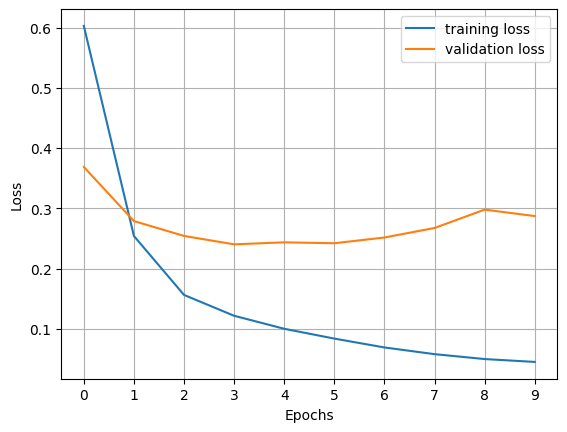

In [72]:
import matplotlib.pyplot as plt
h = history.history
plt.plot(h['loss'], label='training loss')
plt.plot(h['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.xticks(range(epochs))
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('figs/transforner_loss.png')

## Baseline n°2: CRF Implementation with sklearn

In [6]:
from src.crf_baseline import * 
from IPython.display import display

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload

# notebook will reload external python modules;
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def read_raw_input(filename):
    """Read a train/test file and return the contents as a list of list of lists. 
    
    The innermost list is a record of 4 items, one per word.
    The middle-level list contains all the records in one sentence.
    """

    all_items = []

    with open(filename) as fh:
        current_item = []
        all_items.append(current_item)

        for line in fh:
            tags = line.strip().split()
            if len(tags) == 0 or tags[0] == '-DOCSTART-':
                continue
            current_item.append(tags)
            if tags[0] == '.' and tags[1] == '.':
                current_item = []
                all_items.append(current_item)
                
    return all_items

train_sents = read_raw_input('./data/CoNLL-2003_train.txt')
test_sents = read_raw_input('./data/CoNLL-2003_test.txt')

display(train_sents[0])

[['EU', 'NNP', 'B-NP', 'B-ORG'],
 ['rejects', 'VBZ', 'B-VP', 'O'],
 ['German', 'JJ', 'B-NP', 'B-MISC'],
 ['call', 'NN', 'I-NP', 'O'],
 ['to', 'TO', 'B-VP', 'O'],
 ['boycott', 'VB', 'I-VP', 'O'],
 ['British', 'JJ', 'B-NP', 'B-MISC'],
 ['lamb', 'NN', 'I-NP', 'O'],
 ['.', '.', 'O', 'O']]

In [8]:
train_sents = all_sentences(train_sents)
test_sents  = all_sentences(test_sents)
train_sents[0]

,word,pos,parse,ner
word_seq_num,,,,
0,EU,NNP,B-NP,B-ORG
1,rejects,VBZ,B-VP,O
2,German,JJ,B-NP,B-MISC
3,call,NN,I-NP,O
4,to,TO,B-VP,O
5,boycott,VB,I-VP,O
6,British,JJ,B-NP,B-MISC
7,lamb,NN,I-NP,O
8,.,.,O,O


In [9]:
X_train = get_feature_values(train_sents)
X_test = get_feature_values(test_sents)
y_train, y_test = get_labels(train_sents), get_labels(test_sents)

100%|██████████| 1627/1627 [01:04<00:00, 25.42it/s]


In [14]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=200,
    verbose=False,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

labels = list(crf.classes_)
labels.remove('O')
display(labels)

['B-ORG', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC']

CPU times: user 1min, sys: 65.4 ms, total: 1min
Wall time: 1min


Results of CRF:

In [15]:
y_pred = crf.predict(X_test)
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)
print(f" flat f1 score: {f1_score:.2f}")

report = calculate_metrics_crf(y_test, y_pred, labels)
print(f"{report}")

 flat f1 score: 0.81
              precision    recall  f1-score   support

       B-LOC      0.870     0.839     0.854      1668
       I-LOC      0.801     0.720     0.758       257
      B-MISC      0.800     0.748     0.773       702
      I-MISC      0.628     0.657     0.643       216
       B-ORG      0.802     0.723     0.761      1661
       I-ORG      0.655     0.734     0.692       835
       B-PER      0.829     0.853     0.841      1617
       I-PER      0.867     0.947     0.905      1156

   micro avg      0.809     0.806     0.808      8112
   macro avg      0.782     0.778     0.778      8112
weighted avg      0.811     0.806     0.807      8112



Results without chunking (to compare with other models)

In [21]:
def remove_chunking(labels: list):
    """Remove chunking information from a list of labels.
    
    For example, the label 'B-ORG' becomes 'ORG'.
    """
    return [label.split('-')[1] if '-' in label else label for label in labels]

def remove_chunking_from_dataset(dataset: list):
    """Remove chunking information from a dataset."""
    return [remove_chunking(labels) for labels in dataset]

In [22]:
y_test_no_chunks = remove_chunking_from_dataset(y_test)
y_pred_no_chunks = remove_chunking_from_dataset(y_pred)

In [33]:
print(y_test_no_chunks[0])
print(y_pred_no_chunks[0])

['O', 'O', 'LOC', 'O', 'O', 'O', 'O', 'PER', 'O', 'O', 'O', 'O']
['O', 'O', 'LOC', 'O', 'O', 'O', 'O', 'LOC', 'O', 'O', 'O', 'O']


In [32]:
labels_no_chunks = remove_chunking(labels)
labels_no_chunks = np.unique(labels_no_chunks).tolist()
labels_no_chunks

['LOC', 'MISC', 'ORG', 'PER']

In [34]:
report = calculate_metrics_crf(y_test_no_chunks, y_pred_no_chunks, labels_no_chunks)
print(f"{report}")

              precision    recall  f1-score   support

         PER      0.857     0.904     0.880      2773
        MISC      0.777     0.746     0.761       918
         LOC      0.865     0.826     0.845      1925
         ORG      0.766     0.747     0.756      2496

   micro avg      0.823     0.820     0.821      8112
   macro avg      0.816     0.806     0.811      8112
weighted avg      0.822     0.820     0.820      8112

